# Exam - Advanced Methods in Applied Statistics 2024 - Emilie Jessen

## Problem 2

In [37]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import pandas as pd
import scipy 
from iminuit import Minuit
import nestle

In [7]:
# Set som plotting standards:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}
mpl.rc('font', **font)

axes = {'facecolor': 'ghostwhite'}
mpl.rc('axes', **axes)

# Add grid
mpl.rc('axes', grid=True)

# Set custom color cycle
custom_colors= ['dodgerblue', 'red', 'limegreen', 'orange', 'orchid', 'black', 'slategrey', 
                'navy', 'magenta', 'forestgreen', 'lightblue', 'maroon', 'gold', 'lightcoral', 
                'mediumseagreen', 'darkorange', 'darkviolet', 'dimgray', 'darkblue', 'darkred',]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)

# Set inside tickmarks
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True

In [8]:
save_plots = False
np.random.seed(42)

### Problem 2a

Many of the functions used in this problem is identical or inspired by Sophia Wilson and can be found at: 

https://github.com/sophiawilson18/AdvAppStat/tree/main

In [9]:
data = np.loadtxt('Data/Exam_2024_Problem2.txt', skiprows=1)

In [10]:
azi = data[:,0]
zen = data[:,1]

In [86]:
def mollweide_projection(azi, zen, ax, title='Visualization of Data on Mollweide Projection'):
    # Background settings
    ax.set_facecolor('gainsboro')
    ax.grid(color='white')
    
    # Meridian - zenith angle from 0rad to pi (0deg to 180 deg) -pi/2 so instead goes from -pi to pi
    meridian = np.stack([np.zeros(100), np.linspace(0,np.pi,100) - np.pi/2], axis=1)
    
    # Equator from 0 rad to 2pi - pi
    equator = np.stack([np.linspace(0,2*np.pi,100) - np.pi, np.zeros(100)], axis=1)
    
    # Display it
    ax.plot(equator[:,0], equator[:,1], lw=1, color='w')
    ax.plot(meridian[:,0], meridian[:,1], lw=1, color='w')

    # Plot the data
    ax.scatter(azi-np.pi, -zen+np.pi/2, marker='*', color='orange', s=50, zorder=2, label='Data')

    # Title
    ax.set_title(title)

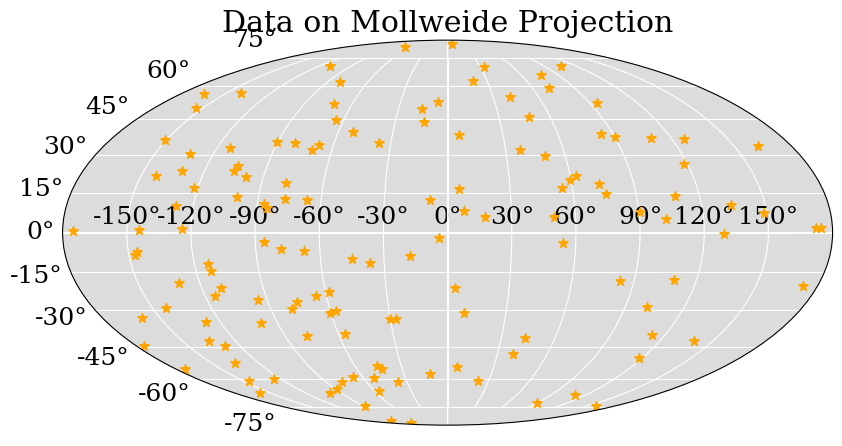

In [87]:
# Plot the data

fig, ax = plt.subplots(1, 1, figsize=(10,5), subplot_kw={'projection': 'mollweide'})
mollweide_projection(azi, zen, ax, title='Data on Mollweide Projection')

if save_plots:
    plt.savefig('Plots/Prob2_Data_Mollweide.png', dpi=300)

In [13]:
def sample_isotropic_data(seed, N_points):
    """Function to sample isotropic data in azimuthal and zenith angles"""
    np.random.seed(seed)
    MC_azi = np.random.uniform(low=0, high=2*np.pi, size=N_points)
    MC_cos_zen = np.random.uniform(low=-1, high=1, size=N_points)
    MC_zen = np.arccos(MC_cos_zen)
    return MC_azi, MC_zen 

In [14]:
def two_point_func(azi_arr, zen_arr):
    'Counts the pairs of events that are within a angular distance ϕ'
    
    # Define number of points
    N_tot = len(azi_arr)
    
    # Convert each point into cartesian coordinates (get unit vectors: r=1)
    r = 1
    Nx_arr = r * np.cos(azi_arr) * np.sin(zen_arr)
    Ny_arr = r * np.sin(azi_arr) * np.sin(zen_arr)
    Nz_arr = r * np.cos(zen_arr)
    
    # Defining the range of cos phi's (x-axis)
    N_bins = 50
    cos_phi_bins = np.linspace(-1, 1, N_bins)

    # Array to store angular distance pairs, i.e. all cos_phi_ij
    cos_phi_ij_arr = []
    
    # Loop over N_tot (outer sum)
    for i in range(0,N_tot):
        # Loop over i-1 (inner sum)
        for j in range(0,i):
            
            # Compute the angular distance cos(phi_ij) as the dot product of N_i dot N_j
            cos_phi_ij = Nx_arr[i]*Nx_arr[j] + Ny_arr[i]*Ny_arr[j] + Nz_arr[i]*Nz_arr[j]
            
            # Store it
            cos_phi_ij_arr.append(cos_phi_ij)

    
    # Emmpty array to store two point auto correlation function (y-values)
    two_point_arr = []
    
    # Loop over our cos phi bins (x-values)
    for i in range(N_bins):
        
        # =1 for x>= 0, =0 for x<0
        heaviside = np.heaviside(cos_phi_ij_arr - cos_phi_bins[i], 0)
        two_point = ( 2/(N_tot*(N_tot-1)) ) * np.sum( heaviside )
        
        # Store it
        two_point_arr.append(two_point)
    
    # Calculate the isotropic prediction
    'This cumulative two point auto-correlation function for the data can'
    'then be compared to the predicted function for perfect isotropic data'
    
    iso_pred = (1/2)*(1-cos_phi_bins)
    
    return cos_phi_bins, two_point_arr, iso_pred

In [15]:
def KS_test(data1, data2): 
    return np.max(np.abs(data1 - data2))

In [25]:
# Calculate the two point function for the data and get predicted isotropic function
cos_bins, data_auto_corr, data_iso_pred = two_point_func(azi, zen)

# Perform the KS test
data_KS = KS_test(data_auto_corr, data_iso_pred)

# Print the result
print(f'The KS test statistic for the data is: {data_KS:.5f}')

The KS test statistic for the data is: 0.02257


In [41]:
# Plot the two point function for the data and the isotropic prediction
def KS_plot(x, y, y_pred, fig, ax, label='Cumulative auto-correlation of data'):
    for i in range(2):
        ax[i].grid(color='grey', alpha=0.3)
    
    # Plot the two functions
    ax[0].plot(x, y, color='k', label=label)
    ax[0].plot(x, y_pred, color='r', label='Predicted cumulative auto-correlation for isotropic data')
    ax[0].legend(loc='upper right', prop={'size':15})

    # Plot the residuals in subplot below
    resi = y_pred-y
    ax[1].plot(x, resi, color='k', label='Residual')
    ax[1].hlines(0, x[0], x[-1], linestyle='dashed', color='r')
    ax[1].legend(prop={'size':15})

    # ---------- Plot zoom -------------
    # Create extra axis
    ax1 = fig.add_axes([0.18, 0.35, 0.27, 0.25]) # add_axes([x0, y0, width, height])
    #ax1.set_facecolor('gainsboro')
    ax1.grid(color='grey', alpha=0.3)

    # Plot again
    ax1.plot(x, y, color='k')
    ax1.plot(x, y_pred ,color='r')
    

    # Get supremum index
    index = np.argmax(abs(resi))
    KS_H0 = KS_test(y, y_pred)
    #KS_MC_H0 = aas.KS_test(MC_y, MC_y_pred)

    # Adjust limits
    if resi[index] > 0: # y_pred is highest at supremum
        ymin, ymax = y[index] - resi[index], y_pred[index] + resi[index]

    if resi[index] < 0: # y is highest at supremum
        ymin, ymax = y_pred[index] + resi[index], y[index] - resi[index]

    xmin, xmax = x[index] - 0.05 * x[index], x[index] + 0.05 * x[index]

    ax1.set_xlim(xmin, xmax)
    ax1.set_ylim(ymin, ymax)

    # Mark supremum
    supremum = ConnectionPatch(xyA=(x[index], y_pred[index]), xyB=(x[index], y[index]), coordsA=ax1.transData, 
                               arrowstyle='<->', color='k')
    fig.add_artist(supremum)
    ax1.set_title(f'KS = {KS_H0:.4f}', color='k', fontsize=14)

    # Add zoom lines
    con1 = ConnectionPatch(xyA=(xmin, ymin), coordsA=ax[0].transData, xyB=(xmax, ymin), coordsB=ax1.transData, alpha=0.5)
    con2 = ConnectionPatch(xyA=(xmax, ymax), coordsA=ax[0].transData, xyB=(xmax,ymax), coordsB=ax1.transData, alpha=0.5)

    sq1 = ConnectionPatch(xyA=(xmin, ymin), xyB=(xmax, ymin), coordsA=ax[0].transData, alpha=0.5)
    sq2 = ConnectionPatch(xyA=(xmin, ymax), xyB=(xmax, ymax), coordsA=ax[0].transData, alpha=0.5)
    sq3 = ConnectionPatch(xyA=(xmin, ymin), xyB=(xmin, ymax), coordsA=ax[0].transData, alpha=0.5)
    sq4 = ConnectionPatch(xyA=(xmax, ymin), xyB=(xmax, ymax), coordsA=ax[0].transData, alpha=0.5)

    fig.add_artist(con1)
    fig.add_artist(con2)
    fig.add_artist(sq1)
    fig.add_artist(sq2)
    fig.add_artist(sq3)
    fig.add_artist(sq4)
    # ----------------------------------

    ax[0].tick_params(axis='both', which='major', labelsize=15)
    ax[0].tick_params(axis='both', which='minor', labelsize=15)
    ax[1].tick_params(axis='both', which='major', labelsize=15)
    ax[1].tick_params(axis='both', which='minor', labelsize=15)
    ax1.tick_params(axis='both', which='major', labelsize=12)
    ax1.tick_params(axis='both', which='minor', labelsize=12)

    ax[1].set_xlabel(r'$cos(\phi)$', fontsize=20)
    ax[0].set_ylabel(r'$\mathcal{C}(cos(\phi))$', fontsize=20)

    ax[0].set_title('KS test of cumulative two-point auto-correlation function')

    plt.show()


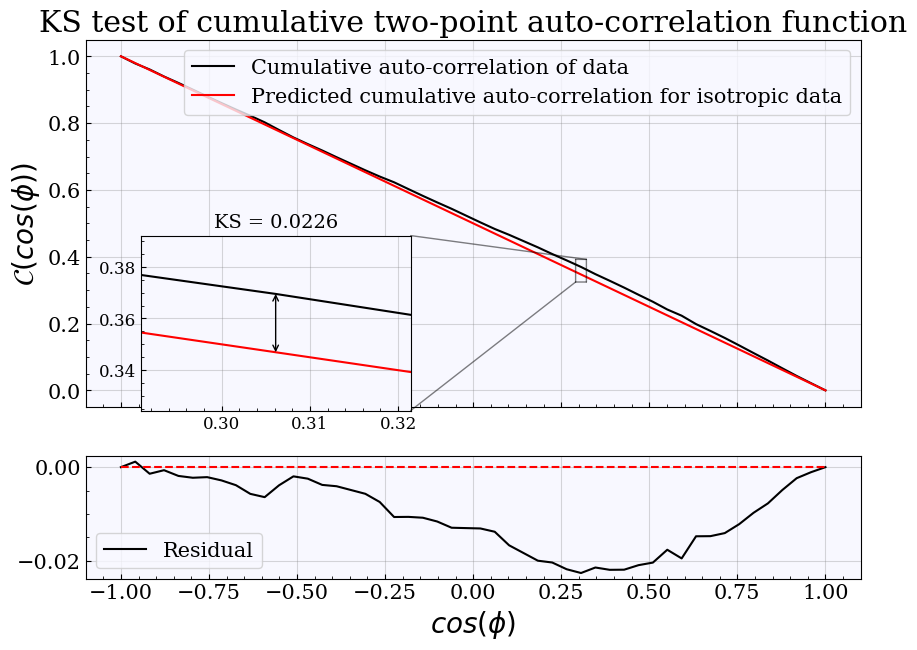

In [44]:
fig, ax = plt.subplots(2, 1, figsize=(10,7), sharex=True, gridspec_kw={'height_ratios': [3, 1]})
KS_plot(cos_bins, data_auto_corr, data_iso_pred, fig, ax)

if save_plots:
    plt.savefig('Plots/Prob2_KS_test.png', dpi=300)

In [46]:
# Sample isotropic data and perform the KS test
N_trials = 1000
N_points = len(azi)
KS_values = np.zeros(N_trials)

for i in range(N_trials):
    MC_azi, MC_zen = sample_isotropic_data(i, N_points)
    _, MC_auto_corr, iso_pred = two_point_func(MC_azi, MC_zen)
    KS_values[i] = KS_test(MC_auto_corr, iso_pred)

In [47]:
def p_val(data, cut): 
    """Function to compute the p-value for the KS test. 
    The p-value is the fraction of data points that are above the cut value."""
    return np.sum(data > cut) / len(data)

# Compute the p-value for the KS test
p_value = p_val(KS_values, data_KS)

# Print the result
print(f'The p-value for the data is: {p_value:.5f}')

The p-value for the data is: 0.00400


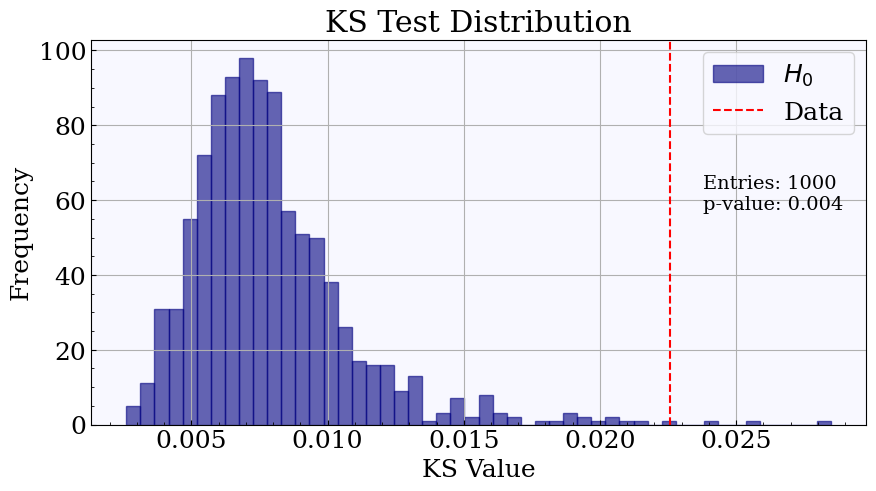

In [93]:
# Plot the distribution of KS values

fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.hist(KS_values, bins=50, label=r'$H_0$', alpha=0.6, color='navy', edgecolor='navy')
ax.axvline(data_KS, color='r', label='Data', linestyle='dashed')
ax.set_xlabel('KS Value')
ax.set_ylabel('Frequency')
ax.set_title('KS Test Distribution')
ax.legend(loc='upper right')

# Add text with entries and p-value
textstr = f'Entries: {N_trials}\np-value: {p_value:.3f}'

ax.text(0.79, 0.65, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top');

### Problem 2b

In [71]:
# Define a function to simulate data from hypothesis A
def sample_HA(seed, N_points=len(data)):
    
    # Set seed
    np.random.seed(seed)
    
    # Get number of points to sample uniformly in specified range
    N_uniform = int(0.2 * N_points)
    
    # Define uniform range
    uni_azim_range = (0.225*np.pi, 0.725*np.pi)
    uni_zeni_range = (0.30*np.pi, 1*np.pi)
    
    # Sample from uniform distributions within range
    uni_azim = np.random.uniform(*uni_azim_range, size=N_uniform)
    uni_zeni = np.random.uniform(*uni_zeni_range, size=N_uniform)
    
    # Sample the rest isotropically
    iso_azim = np.random.uniform(low=0, high=2*np.pi, size=N_points-N_uniform)
    iso_cos_zeni = np.random.uniform(low=-1, high=1, size=N_points-N_uniform)
    iso_zeni = np.arccos(iso_cos_zeni)
    
    # Concatenate arrays
    MC_azim = np.concatenate([uni_azim, iso_azim])
    MC_zeni = np.concatenate([uni_zeni, iso_zeni])
    
    return MC_azim, MC_zeni


# Define a function to simulate data from hypothesis B
def sample_HB(seed, N_points=len(data)):
    
    # Set seed
    np.random.seed(seed)
    
    # Get number of points to sample uniformly in specified range
    N_uniform = int(0.15 * N_points)
    
    # Define uniform range
    uni_azim_range = (0*np.pi, 1*np.pi)
    uni_zeni_range = (0.5*np.pi, 1*np.pi)
    
    # Sample from uniform distributions within range
    uni_azim = np.random.uniform(*uni_azim_range, size=N_uniform)
    uni_zeni = np.random.uniform(*uni_zeni_range, size=N_uniform)
    
    # Sample the rest isotropically
    iso_azim = np.random.uniform(low=0, high=2*np.pi, size=N_points-N_uniform)
    iso_cos_zeni = np.random.uniform(low=-1, high=1, size=N_points-N_uniform)
    iso_zeni = np.arccos(iso_cos_zeni)
    
    # Concatenate arrays
    MC_azim = np.concatenate([uni_azim, iso_azim])
    MC_zeni = np.concatenate([uni_zeni, iso_zeni])
    
    return MC_azim, MC_zeni

In [72]:
KS_HA_arr = np.zeros(N_trials)
KS_HB_arr = np.zeros(N_trials)

for i in range(N_trials):
    MC_HA_azi, MC_HA_zen = sample_HA(i)
    MC_HB_azi, MC_HB_zen = sample_HB(i)
    
    _, MC_HA_auto_corr, HA_iso_pred = two_point_func(MC_HA_azi, MC_HA_zen)
    _, MC_HB_auto_corr, HB_iso_pred = two_point_func(MC_HB_azi, MC_HB_zen)
    
    KS_HA_arr[i] = KS_test(MC_HA_auto_corr, HA_iso_pred)
    KS_HB_arr[i] = KS_test(MC_HB_auto_corr, HB_iso_pred)

In [83]:
# Compute the p-values for the KS tests
# Compare isotropic data to hypothesis A
# Compare isotropic data to hypothesis B

HA_median = np.median(KS_HA_arr)
HB_median = np.median(KS_HB_arr)

HA_p_value = p_val(KS_values, HA_median)
HB_p_value = p_val(KS_values, HB_median)

print(f'The p-value for hypothesis A is: {HA_p_value:.5f}')
print(f'The p-value for hypothesis B is: {HB_p_value:.5f}')

The p-value for hypothesis A is: 0.01600
The p-value for hypothesis B is: 0.09500


In [108]:
bin_range

[[0.002610866054272687], [0.06126279100942844]]

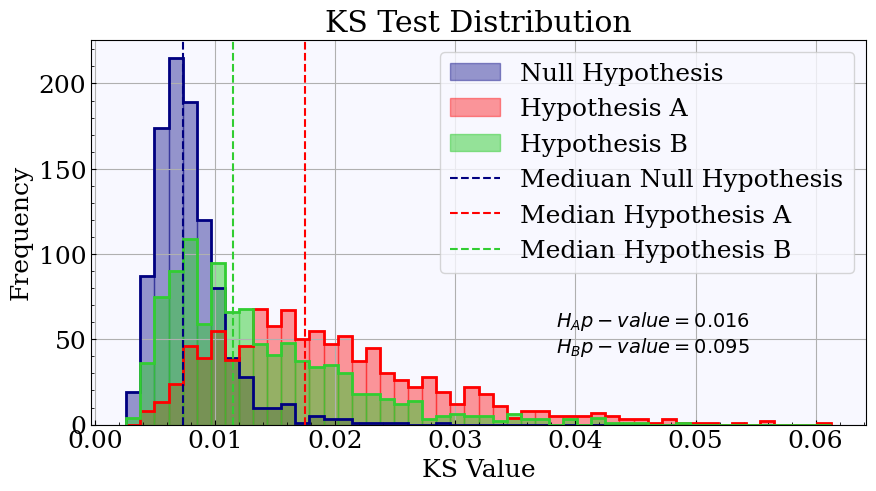

In [118]:
# Plot all three distributions together

bin_range = [min(KS_values.min(), KS_HA_arr.min(), KS_HB_arr.min()),
                 max(KS_values.max(), KS_HA_arr.max(), KS_HB_arr.max())]

fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.hist(KS_values, bins=50, range=bin_range, label='Null Hypothesis', color='navy', alpha=0.4, edgecolor='navy')
ax.hist(KS_values, bins=50, range=bin_range, histtype='step', color='navy', linewidth=2) 

ax.hist(KS_HA_arr, bins=50, range=bin_range, label='Hypothesis A', color='red', alpha=0.4, edgecolor='red')
ax.hist(KS_HA_arr, bins=50, range=bin_range, histtype='step', color='red', linewidth=2)

ax.hist(KS_HB_arr, bins=50, range=bin_range, label='Hypothesis B', color='limegreen', alpha=0.5, edgecolor='limegreen')
ax.hist(KS_HB_arr, bins=50, range=bin_range, histtype='step', color='limegreen', linewidth=2)

ax.set_xlabel('KS Value')
ax.set_ylabel('Frequency')
ax.set_title('KS Test Distribution')


# Plot vertical lines with median values
ax.axvline(np.median(KS_values), color='navy', linestyle='dashed', label='Mediuan Null Hypothesis')
ax.axvline(HA_median, color='red', linestyle='dashed', label='Median Hypothesis A')
ax.axvline(HB_median, color='limegreen', linestyle='dashed', label='Median Hypothesis B')

ax.legend(loc='upper right')

# Add text with entries and p-value
textstr = '\n'.join((
    r'$H_A  p-value=%.3f$' % (HA_p_value),
    r'$H_B  p-value=%.3f$' % (HB_p_value)))

ax.text(0.6, 0.3, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top')

if save_plots:
    plt.savefig('Plots/Prob2_KS_test_all.png', dpi=300)